In [1]:
!hostname

gnode011.cluster


In [2]:
!nvidia-smi

Wed Aug  2 11:09:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   32C    P0    62W / 300W |   1520MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


#### Parameters 
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 



# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
w1=np.random.randn(sec_length,batch)
w2=np.random.randn(sec_length,batch)
print(ini.shape, w1.shape, w2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = w1
Traj[:,:,1] = w2
T=np.arange(len(w1[:,1]))
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 213 ms, sys: 33.2 ms, total: 246 ms
Wall time: 516 ms


In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


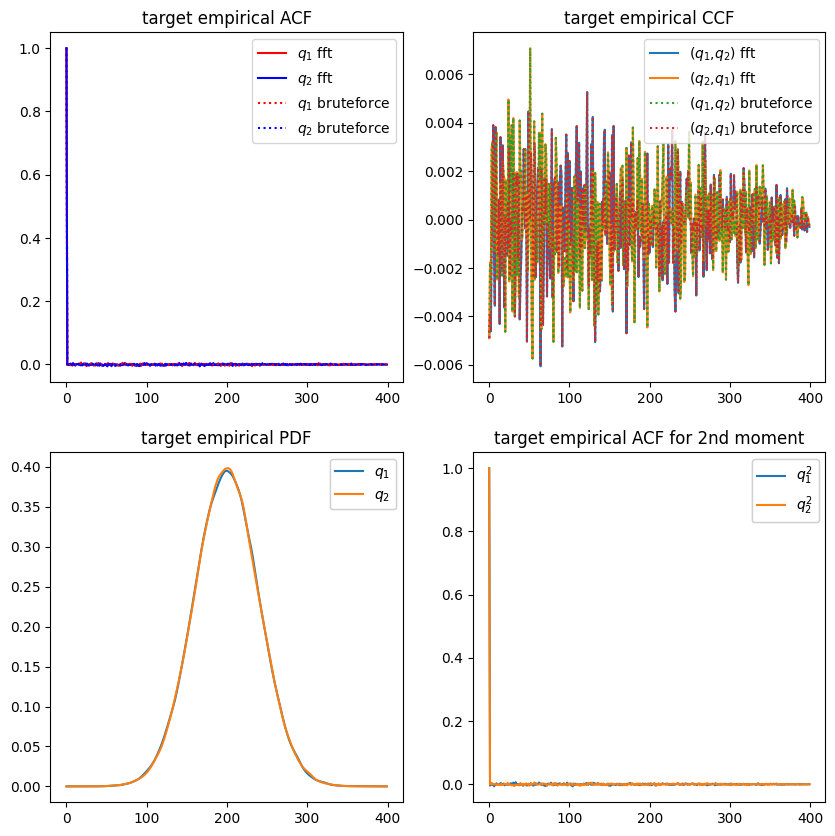

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,0], label=r'($q_1$,$q_2$) fft')
axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1], label=r'($q_2$,$q_1$) fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,0],':',label=r'($q_1$,$q_2$) bruteforce')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1],':',label=r'($q_2$,$q_1$) bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', r'$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

In [11]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_acf=[]
V_acf=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf2=[]
V_acf2=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            acf = loss_acf_bruteforce(pred_val)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, acf_sec_moment))
            T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
            V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if acf <=0.0001 and ccf <=0.000005 and pdf<=0.00002 and acf_sec_moment<=0.0001:
            break

if acf > 0.0001 or ccf > 0.000005 or pdf >0.00002 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 0.2698, 0.2681, acf: 0.00267, ccf: 0.00376, pdf: 0.25900, acf2: 0.00266
[50]-th step loss: 0.2601, 0.2601, acf: 0.00064, ccf: 0.00012, pdf: 0.25864, acf2: 0.00065
[100]-th step loss: 0.2591, 0.2590, acf: 0.00022, ccf: 0.00017, pdf: 0.25843, acf2: 0.00022
[150]-th step loss: 0.2587, 0.2587, acf: 0.00011, ccf: 0.00014, pdf: 0.25832, acf2: 0.00011
[200]-th step loss: 0.2585, 0.2585, acf: 0.00007, ccf: 0.00009, pdf: 0.25829, acf2: 0.00004
[250]-th step loss: 0.2584, 0.2584, acf: 0.00006, ccf: 0.00005, pdf: 0.25828, acf2: 0.00001
[300]-th step loss: 0.2584, 0.2584, acf: 0.00005, ccf: 0.00003, pdf: 0.25827, acf2: 0.00001
[350]-th step loss: 0.2583, 0.2583, acf: 0.00004, ccf: 0.00002, pdf: 0.25825, acf2: 0.00001
[400]-th step loss: 0.2583, 0.2583, acf: 0.00004, ccf: 0.00001, pdf: 0.25821, acf2: 0.00001
[450]-th step loss: 0.2581, 0.2581, acf: 0.00004, ccf: 0.00001, pdf: 0.25803, acf2: 0.00001
[500]-th step loss: 0.2524, 0.2516, acf: 0.00011, ccf: 0.00004, pdf: 0.25140, acf2:

[4450]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4500]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4550]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4600]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4650]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4700]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4750]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4800]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4850]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4900]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00001, acf2: 0.00001
[4950]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 

[8900]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[8950]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9000]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9050]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9100]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9150]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9200]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9250]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9300]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9350]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[9400]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 

[13300]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13350]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13400]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13450]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13500]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13550]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13600]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13650]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13700]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13750]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[13800]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.0

[17700]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[17750]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[17800]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[17850]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[17900]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[17950]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[18000]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[18050]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[18100]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[18150]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.00001, pdf: 0.00000, acf2: 0.00001
[18200]-th step loss: 0.0000, 0.0000, acf: 0.00001, ccf: 0.0

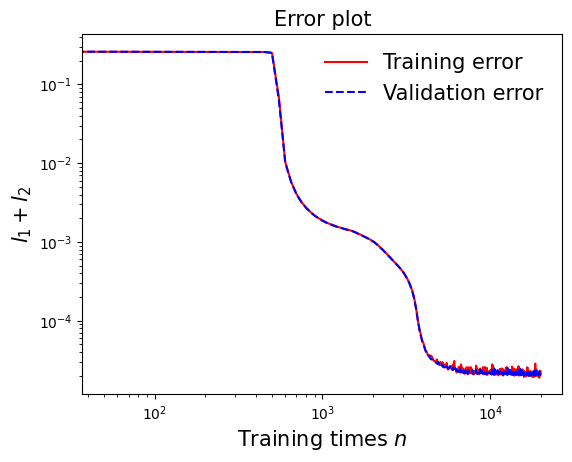

In [13]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

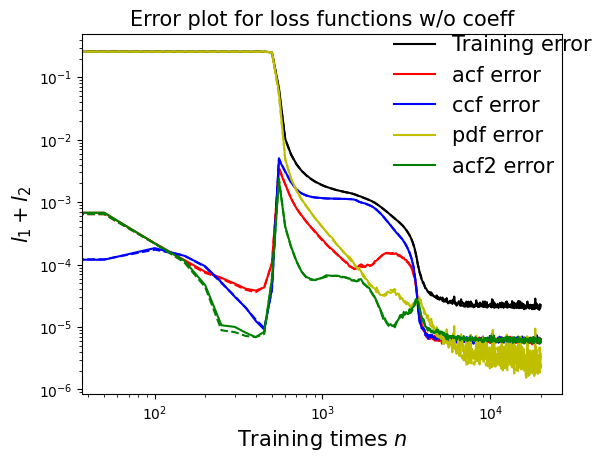

In [14]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_acf,'r',label='acf error')
plt.loglog(Step, V_acf,'r--')
plt.loglog(Step, T_ccf,'b',label='ccf error')
plt.loglog(Step, V_ccf,'b--')
plt.loglog(Step, T_pdf,'y',label='pdf error')
plt.loglog(Step, V_pdf,'y--')
plt.loglog(Step, T_acf2,'g',label='acf2 error')
plt.loglog(Step, V_acf2,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [15]:
def test1(Traj, T, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[:20], Traj[:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[:20], prediction[:20, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$w_1(t)$ and $w_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

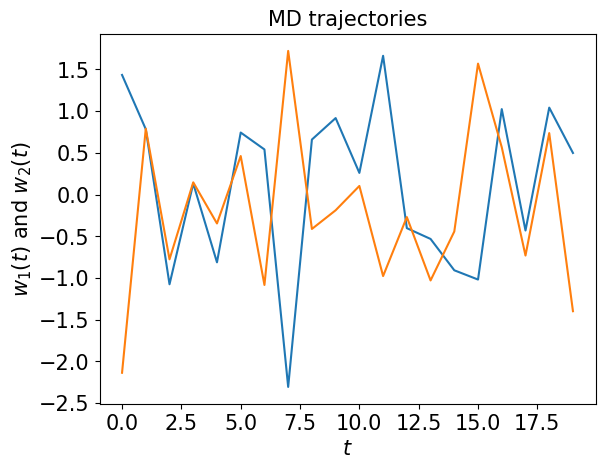

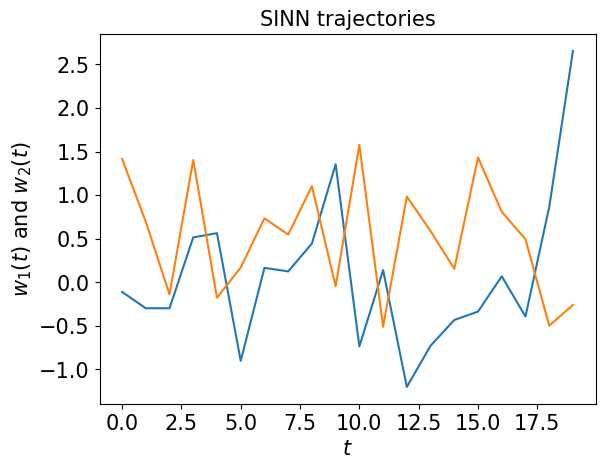

In [16]:
test1(Traj, T, net)

In [17]:
def test2(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T[:10], corr_t2[:10,:],'r')        # correlation function of the target 
    plt.plot(T[:10], corr_p2[:10,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])

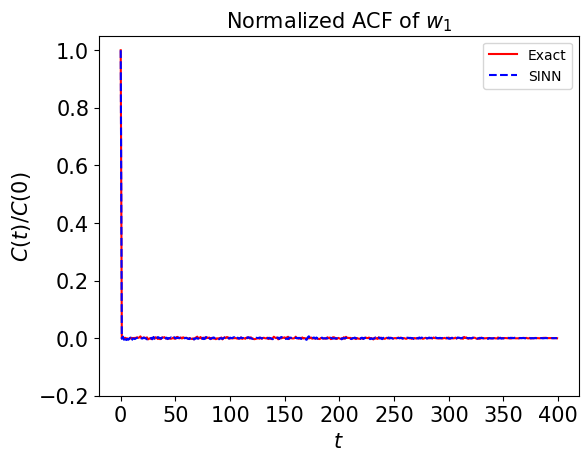

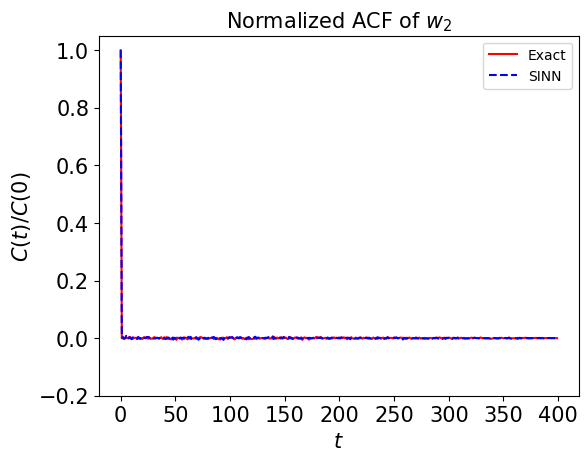

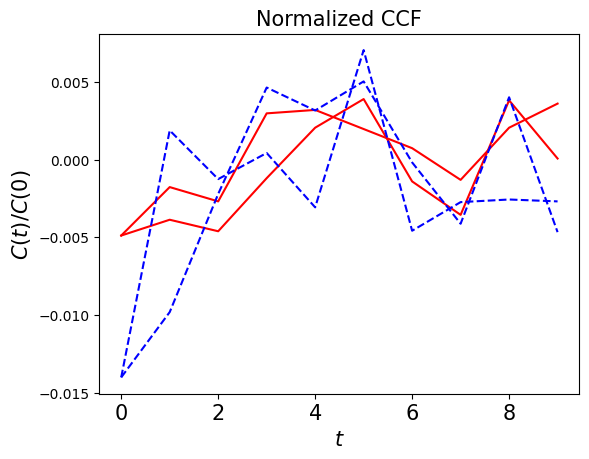

In [18]:
test2(target, net)

In [19]:
def test3(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $w_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $w_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $w_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $w_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

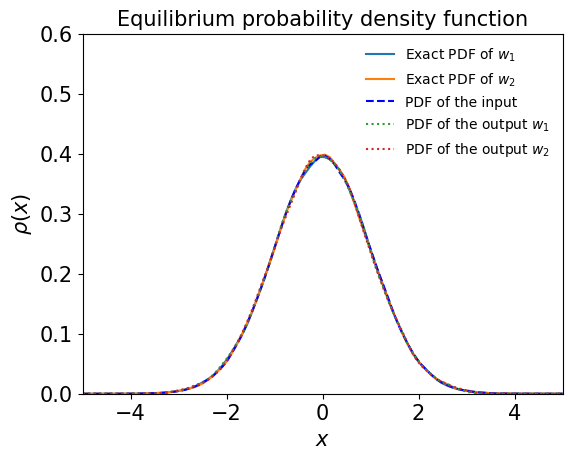

In [20]:
test3(target, net)

In [21]:
def test4(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $w_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()  

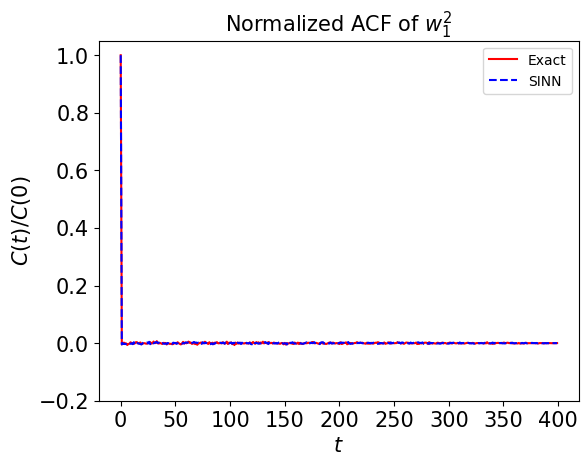

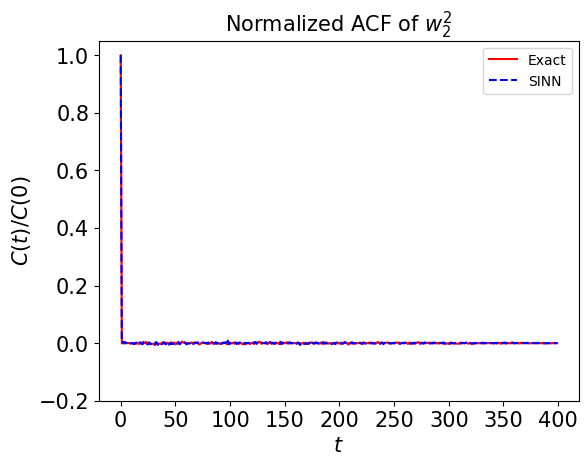

In [22]:
test4(target, net)

# 2 inputs

In [24]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [25]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None,device=device)

In [26]:
### Defining SINN model
net = SINN(2, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [27]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if ccf <=0.00008 and pdf<=0.00002 and acf_sec_moment<=0.0001:
            break

if ccf > 0.00008 or pdf >0.00002 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 0.2605, 0.2601, ccf: 0.00295, pdf: 0.25456, acf: 0.00258
[50]-th step loss: 0.2086, 0.2064, ccf: 0.00475, pdf: 0.19842, acf: 0.00326
[100]-th step loss: 0.0514, 0.0508, ccf: 0.01265, pdf: 0.03031, acf: 0.00787
[150]-th step loss: 0.0335, 0.0334, ccf: 0.01251, pdf: 0.01528, acf: 0.00565
[200]-th step loss: 0.0269, 0.0267, ccf: 0.01089, pdf: 0.01130, acf: 0.00453
[250]-th step loss: 0.0224, 0.0222, ccf: 0.00960, pdf: 0.00865, acf: 0.00399
[300]-th step loss: 0.0188, 0.0188, ccf: 0.00851, pdf: 0.00678, acf: 0.00350
[350]-th step loss: 0.0162, 0.0161, ccf: 0.00756, pdf: 0.00547, acf: 0.00308
[400]-th step loss: 0.0141, 0.0140, ccf: 0.00676, pdf: 0.00450, acf: 0.00269
[450]-th step loss: 0.0122, 0.0122, ccf: 0.00607, pdf: 0.00379, acf: 0.00233
[500]-th step loss: 0.0108, 0.0108, ccf: 0.00550, pdf: 0.00324, acf: 0.00202
[550]-th step loss: 0.0096, 0.0096, ccf: 0.00500, pdf: 0.00282, acf: 0.00174
[600]-th step loss: 0.0085, 0.0086, ccf: 0.00458, pdf: 0.00248, acf: 0.00150
[6

[5300]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5350]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5400]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5450]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5500]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5550]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5600]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5650]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5700]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5750]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00002, acf: 0.00001
[5800]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5850]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001, acf: 0.00001
[5900]-th step loss: 0.0013, 0.0013, ccf: 0.00125, pdf: 0.00001,

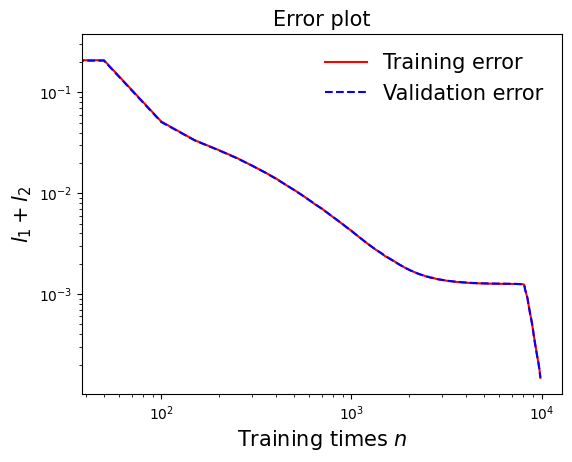

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

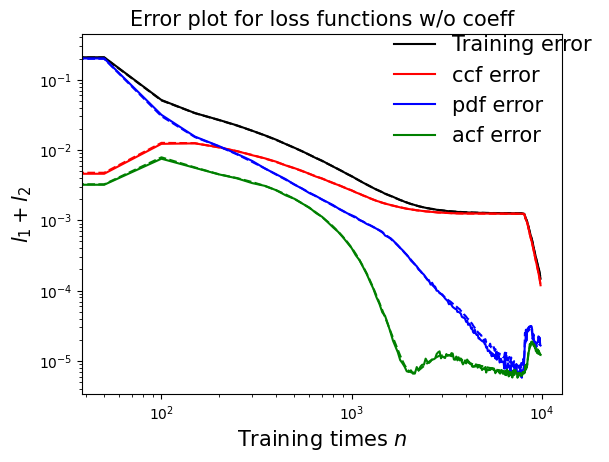

In [29]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

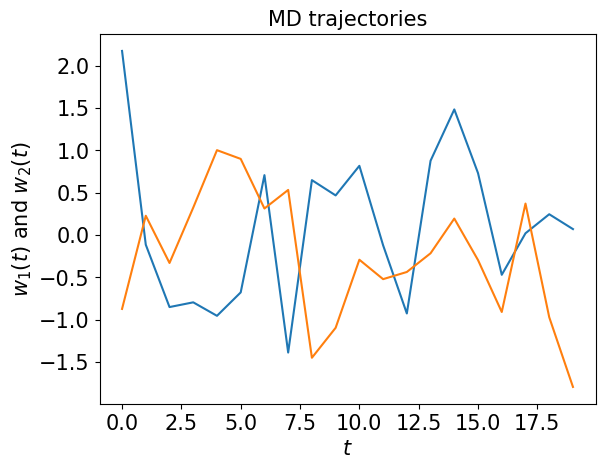

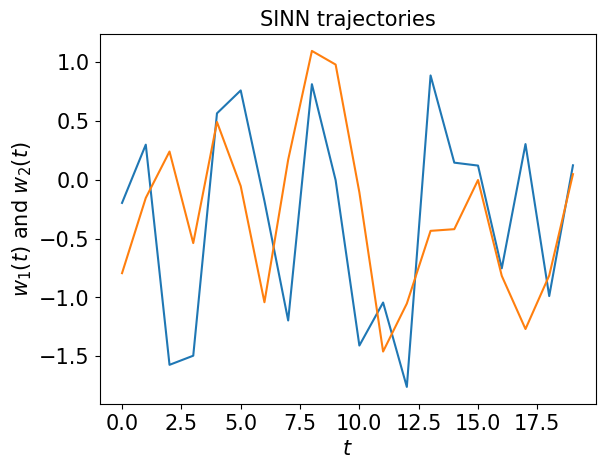

In [30]:
test1(Traj, T, net)

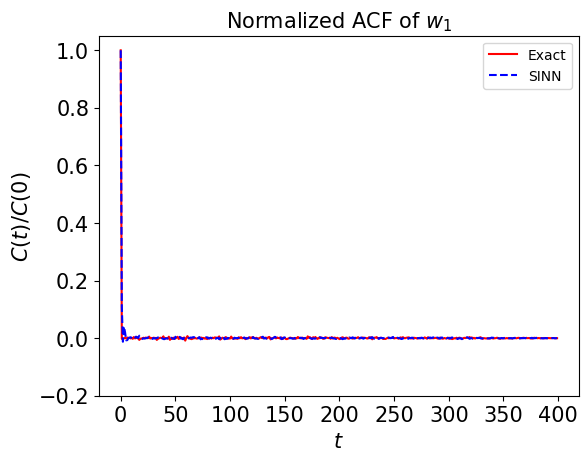

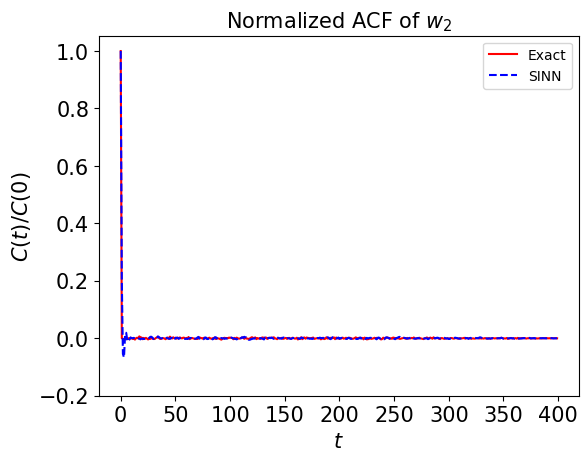

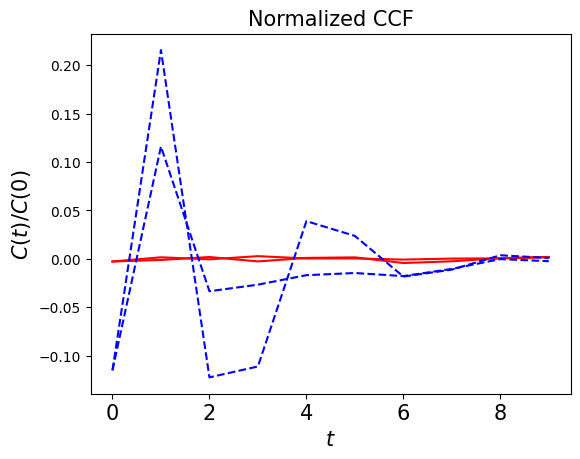

In [31]:
test2(target, net)

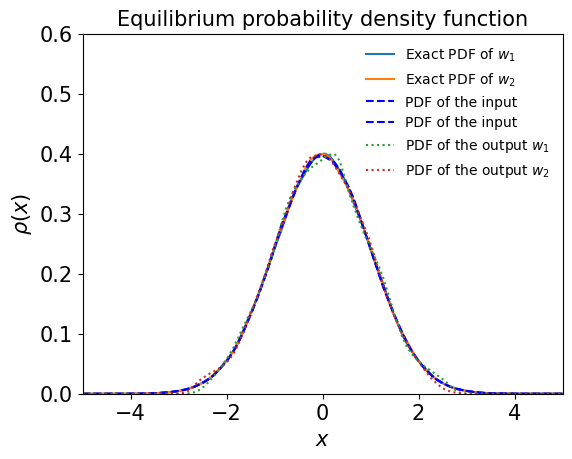

In [32]:
test3(target, net)

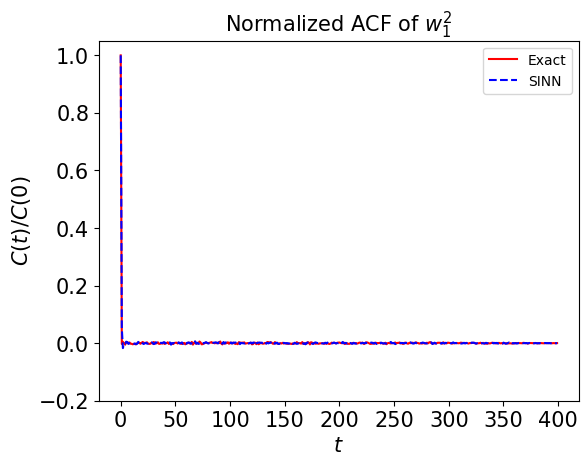

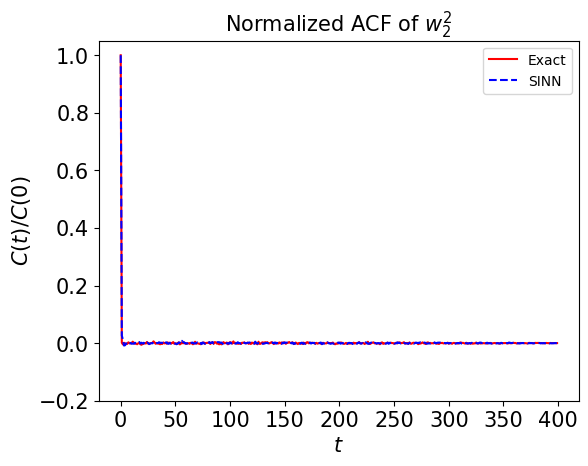

In [33]:
test4(target, net)

# 3 inputs

In [34]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,3*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 3)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 3), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 3]) torch.float32
The torch validation size is torch.Size([800, 400, 3]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [35]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None,device=device)

In [36]:
### Defining SINN model
net = SINN(3, 5, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [37]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,3*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,3)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_ccf_fft(prediction) + loss_pdf_empirical(prediction) + loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_ccf_bruteforce(pred_val)+loss_pdf_empirical(pred_val) + loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if ccf <=0.00012 and pdf<=0.00002 and acf_sec_moment<=0.0001:
            break

if ccf > 0.00012 or pdf >0.00002 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 0.2597, 0.2596, ccf: 0.00110, pdf: 0.25670, acf: 0.00175
[50]-th step loss: 0.2427, 0.2418, ccf: 0.00084, pdf: 0.24034, acf: 0.00061
[100]-th step loss: 0.1356, 0.1318, ccf: 0.00482, pdf: 0.12521, acf: 0.00176
[150]-th step loss: 0.0333, 0.0331, ccf: 0.01049, pdf: 0.01870, acf: 0.00391
[200]-th step loss: 0.0233, 0.0231, ccf: 0.00836, pdf: 0.01158, acf: 0.00316
[250]-th step loss: 0.0177, 0.0175, ccf: 0.00708, pdf: 0.00776, acf: 0.00270
[300]-th step loss: 0.0141, 0.0141, ccf: 0.00623, pdf: 0.00549, acf: 0.00236
[350]-th step loss: 0.0119, 0.0119, ccf: 0.00566, pdf: 0.00410, acf: 0.00209
[400]-th step loss: 0.0104, 0.0103, ccf: 0.00523, pdf: 0.00320, acf: 0.00185
[450]-th step loss: 0.0092, 0.0091, ccf: 0.00488, pdf: 0.00260, acf: 0.00164
[500]-th step loss: 0.0082, 0.0082, ccf: 0.00457, pdf: 0.00217, acf: 0.00145
[550]-th step loss: 0.0074, 0.0074, ccf: 0.00427, pdf: 0.00187, acf: 0.00128
[600]-th step loss: 0.0068, 0.0068, ccf: 0.00400, pdf: 0.00164, acf: 0.00112
[6

[5300]-th step loss: 0.0012, 0.0012, ccf: 0.00117, pdf: 0.00002, acf: 0.00001
[5350]-th step loss: 0.0012, 0.0012, ccf: 0.00116, pdf: 0.00002, acf: 0.00001
[5400]-th step loss: 0.0012, 0.0012, ccf: 0.00115, pdf: 0.00003, acf: 0.00001
[5450]-th step loss: 0.0012, 0.0012, ccf: 0.00114, pdf: 0.00003, acf: 0.00001
[5500]-th step loss: 0.0012, 0.0012, ccf: 0.00113, pdf: 0.00003, acf: 0.00001
[5550]-th step loss: 0.0012, 0.0012, ccf: 0.00112, pdf: 0.00003, acf: 0.00001
[5600]-th step loss: 0.0011, 0.0011, ccf: 0.00110, pdf: 0.00003, acf: 0.00001
[5650]-th step loss: 0.0011, 0.0011, ccf: 0.00109, pdf: 0.00003, acf: 0.00001
[5700]-th step loss: 0.0011, 0.0011, ccf: 0.00107, pdf: 0.00004, acf: 0.00001
[5750]-th step loss: 0.0011, 0.0011, ccf: 0.00105, pdf: 0.00004, acf: 0.00001
[5800]-th step loss: 0.0011, 0.0011, ccf: 0.00102, pdf: 0.00004, acf: 0.00001
[5850]-th step loss: 0.0011, 0.0011, ccf: 0.00100, pdf: 0.00005, acf: 0.00001
[5900]-th step loss: 0.0010, 0.0010, ccf: 0.00097, pdf: 0.00005,

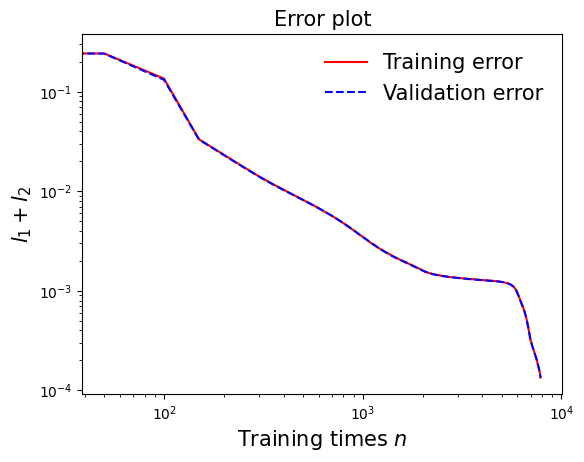

In [38]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

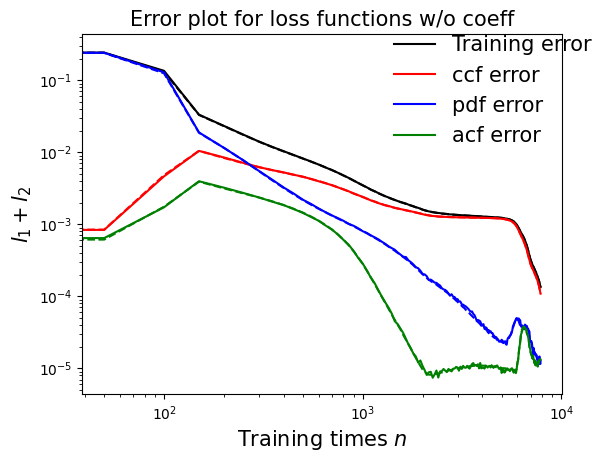

In [39]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

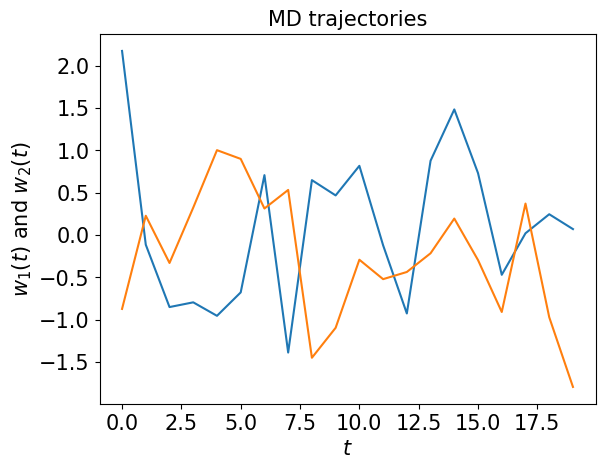

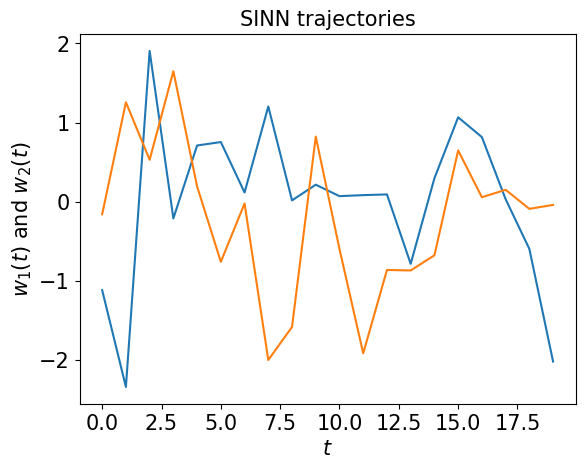

In [40]:
test1(Traj, T, net)

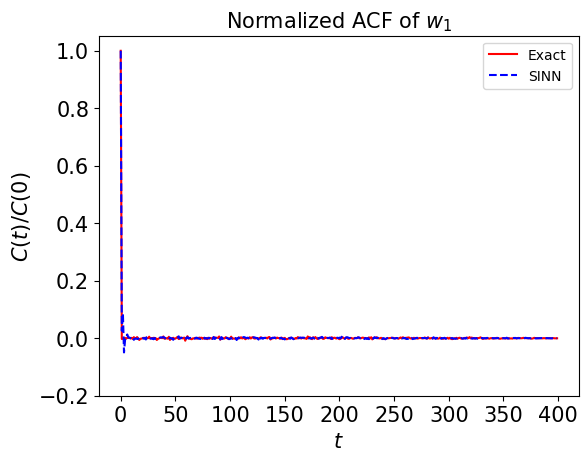

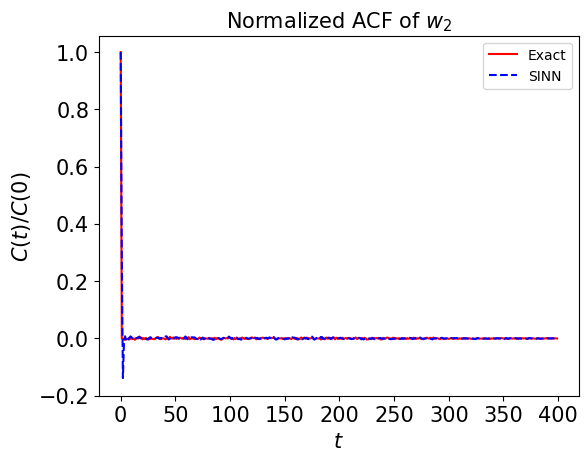

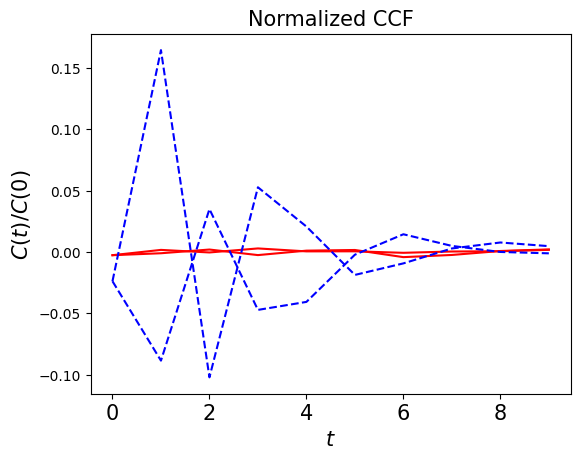

In [41]:
test2(target, net)

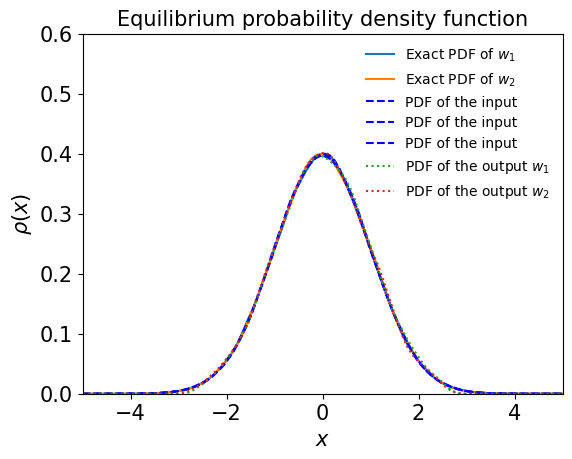

In [42]:
test3(target, net)

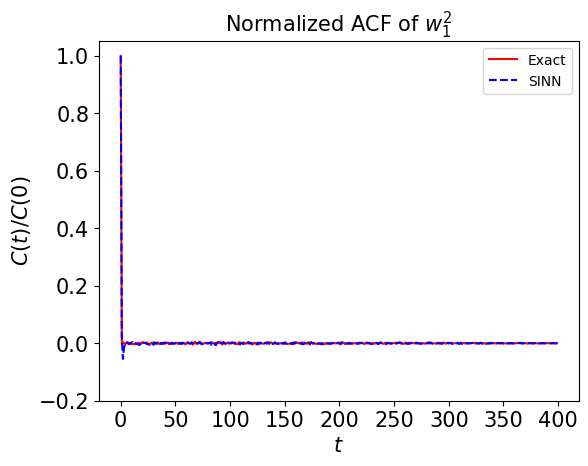

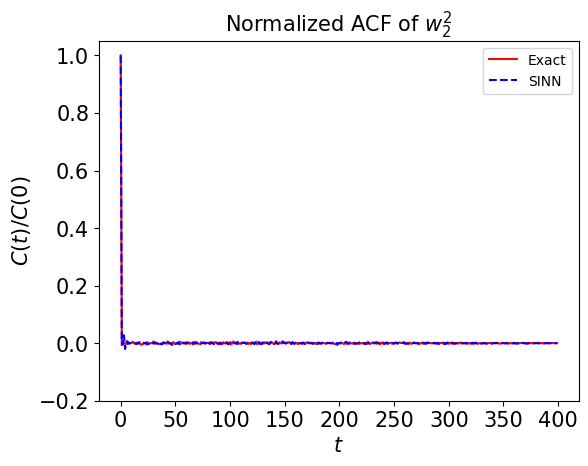

In [43]:
test4(target, net)